In [61]:
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister, assemble
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import pandas as pd
#import matplotlib as mpl
from math import pi
import numpy as np
import matplotlib.pyplot as plt


IBMQ.save_account('0c5f09afe94bb9159f65f3ae983bdad4fd4fe1ef0fe97a1f9167ffc44c733c5ccb21d848987d3c1796fc3a40e2143fc5f902ddb2526a3df548c3b0ea53cba38f')
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2021-09-24 01:37:03,025: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-09-24 01:37:04,778: Credentials are already in use. The existing account in the session will be replaced.


In [66]:
#Superposition Helper function
def superpos(qc,n):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
    return qc


# Example phase-flip oracle
def oracle(n):
    qc = QuantumCircuit(n)
    qc.cz(0,n-1)
    qc.cz(1,n-1)
    O = qc.to_gate().control(1)
    O.name = "O_f"
    return O

#The Oracle and Reflection circuit combined make up the Grover Operator
def R(n):
    qc = QuantumCircuit(n)
    
    superpos(qc, n)

    for i in range(n):
        qc.x(i)

    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)

    for i in range(n):
        qc.x(i)
        
    for i in range(n):
        qc.h(i)
    Us = qc.to_gate().control(1)
    Us.name = "R"
    return Us

#Combined into single Grover Operator
def G(n):

    qc = QuantumCircuit(n)
    qc.cz(0,n-1)
    qc.cz(1,n-1)
    
    superpos(qc, n)

    for i in range(n):
        qc.x(i)

    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)

    for i in range(n):
        qc.x(i)
        
    for i in range(n):
        qc.h(i)
    G = qc.to_gate().control(1)
    G.name = "G"
    return G

#inverse QFT
def qft_dagger(n):
    
    qc= QuantumCircuit(n)
    
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qfti = qc.to_gate()
    qfti.name ='iqft'
    return qfti

def num_iterations(num_solutions, n):
    
    amplitude = np.sqrt(num_solutions / 2 ** n)
    return round(np.arccos(amplitude) / (2 * np.arcsin(amplitude)))

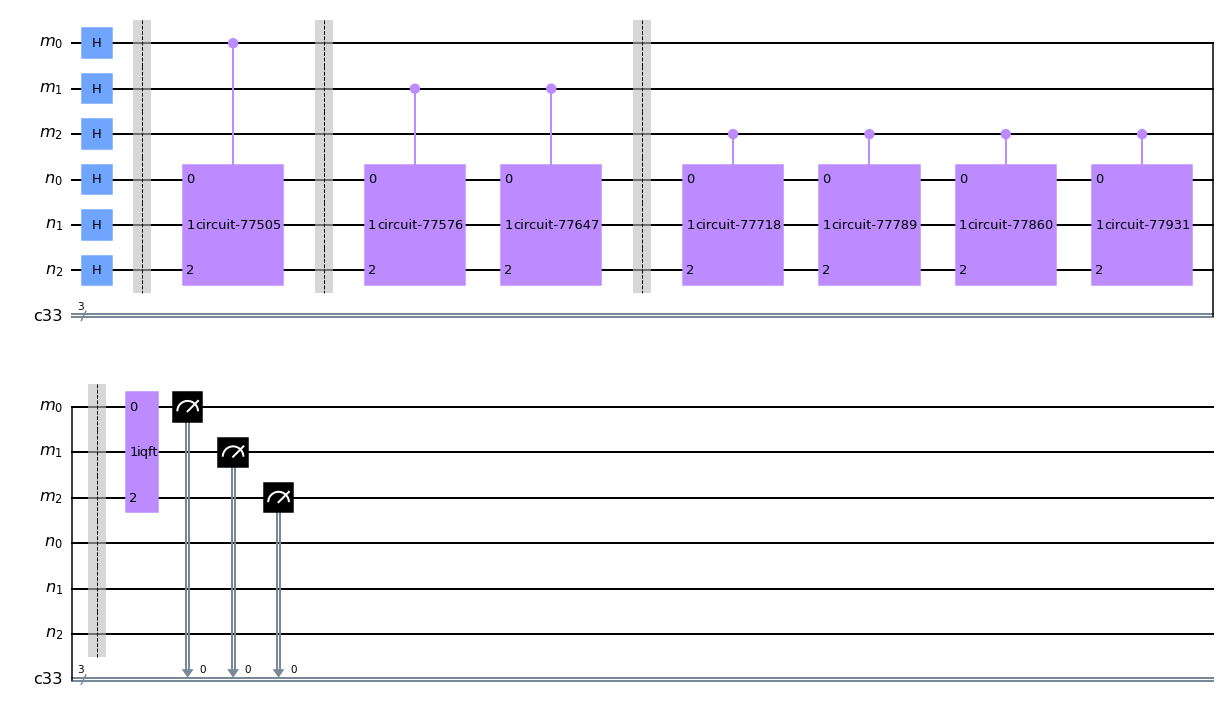

In [107]:
m=3
n=3
qctr = QuantumRegister(m,'m')
qt = QuantumRegister(n,'n')
c = ClassicalRegister(3)
qea_circuit = QuantumCircuit(qctr, qt,c)

#Starting with the QPE part
for qubit in qctr:
    qea_circuit.h(qubit)

#Creating A i.e. equal superposition
for qubit in qt:
    qea_circuit.h(qubit)

#Controlled Powered Grover operators    
for i in range(0,m+1):
    #rep = 2**i
    #print(rep)
    l=[i-1]
    for j in range(m, m+n):
        l.append(j)
    
    for k in range(int(2**(i-1))):
        qea_circuit.append(G(n),l)

    qea_circuit.barrier()

#iqft
qea_circuit.append(qft_dagger(m),list(range(m)))
for ix in range(m):
    qea_circuit.measure(ix,c[0])

qea_circuit.draw('mpl')


001


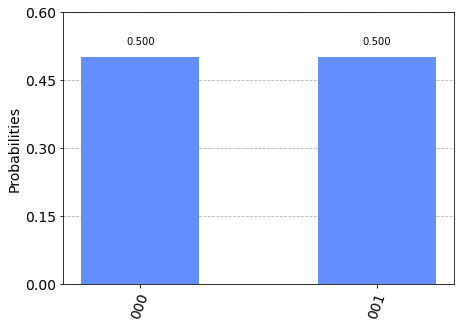

In [97]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qea = transpile(qea_circuit, aer_sim)
qobj = assemble(t_qea, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

print(max(answer))
plot_histogram(answer)